## [PAA] Single- and multi-tissue analysis
### Cathy Wang 9/4/21

Features included: 
- updates "aggregate_data" method, including
    - choice to remove substrates that have negative cleavage rates across all sample conditions
    - choice to standardize
    - incorporated dictionary labels to clustering (may have been rewritten from a previous instance of this functionality)
- create dictionary for substrate name and sequence
- identify top n probes by cleavage rate
- plot histogram distribution of z-scores
- create ranked list of all peptides above cleavage z-score threshold

Requires several Excel files in the same folder: 
- cleavage rate values for samples of interest (i.e. 'MCA_Correlation_Healthy.xlsx')
- inhibitor data "dictionary" file for each substrate (i.e. 'bin_inh_int_FAM_encoded.csv')
- list of peptide names and sequences

In [1]:
#Import packages
import pandas as pd
import scipy as sp
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import os

In [2]:
# remove substrate if there is negative cleavage rate across all samples in dataframe
def process_data(data):
    
    dropping = []
    for ind in data.index:
        if all(x < 0 for x in data.loc[ind]):
            dropping.append(ind)
    
    return dropping

In [3]:
def scale_data(data):
    
    # Create Scaler object
    scaler = preprocessing.StandardScaler()
    # Fit data on the scaler object
    scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    
    return scaled_data

In [4]:
# data: dataframe
# dict_df: dataframe of specificity classifications for substrates
# scale: scale data
# process: remove negative cleavage rates
def aggregate_data(data, dict_df, out_path, title_corr, scale=True, process=True):
    
    # data: Pandas dataframe
    # col_map: Pandas dataframe with substrate and classification (replaced as colors)
    def plot_clustermap(data, col_map, out_path, metric='euclidean', method='average'):
        
        # set up hierarchical clustering plotting
        sns.set(font_scale=1.5)
        
        cmap = sns.diverging_palette(h_neg=240, h_pos=20, sep=15, s=99, l=50, as_cmap=True)
        
        fig = sns.clustermap(data, cmap=cmap, center=0.1, linewidth=2, linecolor='white', dendrogram_ratio=(.15, .15),
                         figsize=(8,8), cbar_pos=(0, 0.12, .03, .4), method=method, row_colors=spec, 
                         metric=metric)

        if scale:
            fig.savefig(os.path.join(out_path, 'clustermap.png'))
        else:
            fig.savefig(os.path.join(out_path, 'clustermap_orig.png'))
            
        return
    
    # plot initial cleavage rates as heatmap
    def plot_heatmap(data, out_path):
        fig = plt.figure(figsize=(10,10))
        sns.heatmap(data)
        plt.tight_layout()
        fig.savefig(os.path.join(out_path, 'initial_rate_heatmap.png'))
    
    def plot_corr_mat(data, title, out_path, method = 'pearson'):
        fig = plt.figure(figsize=(12,10), dpi=200, facecolor='w', edgecolor='k')
        corr_matrix = data.corr(method = method)
        sns.heatmap(corr_matrix, annot=True)
        plt.title(str(title)+' - '+method+ ' correlation')
        plt.tight_layout()
        fig.savefig(os.path.join(out_path, 'corrmat_'+method+'.png'))
        return corr_matrix
    
    def plot_pairwise_scatter(data, out_path):
        num_cols = len(data.columns)

        for col in range(num_cols-1):
            to_plot = np.arange(col+1,num_cols)
            for y in to_plot:
                fig, ax = plt.subplots()
                plt.scatter(data.iloc[:,col], data.iloc[:,y])
                plt.xlabel(str(data.columns[col]))
                plt.ylabel(str(data.columns[y]))
                plt.title(str(data.columns[col])+ ' vs ' + str(data.columns[y]))
                textstr = '\n'.join((r'$Pearson=%.2f$' % (corr_matrix_pearson.iloc[col,y], ),
                                     r'$Spearman=%.2f$' % (corr_matrix_spear.iloc[col,y], )))


                # change matplotlib.patch.Patch properties
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

                # place a text box in upper left in axes coords
                ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                        verticalalignment='top', bbox=props)
                plt.tight_layout()
                fig.savefig(os.path.join(out_path, 'scatter_'+str(data.columns[col])+ '_vs_' + str(data.columns[y])+'.png'))
        return
    
    def plot_pairwise_scatter_color(data, col_map, out_path):
        num_cols = len(data.columns)
        types_enum = np.unique(col_map.values)
        data['color'] = col_map['Specificity']
#         display(data)
        print('types_enum', types_enum)
        for col in range(num_cols-1):
            to_plot = np.arange(col+1,num_cols)
            for y in to_plot:
                fig, ax = plt.subplots()
                for el in types_enum:
                    temp = data[data['color'] == el]
                    plt.scatter(temp.iloc[:,col], temp.iloc[:,y])
                    plt.xlabel(str(temp.columns[col]))
                    plt.ylabel(str(temp.columns[y]))
                    plt.title(str(temp.columns[col])+ ' vs ' + str(temp.columns[y]))
                textstr = '\n'.join((r'$Pearson=%.2f$' % (corr_matrix_pearson.iloc[col,y], ),
                                     r'$Spearman=%.2f$' % (corr_matrix_spear.iloc[col,y], )))

                # change matplotlib.patch.Patch properties
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

                # place a text box in upper left in axes coords
                ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                        verticalalignment='top', bbox=props)
                fig.savefig(os.path.join(out_path, 'col_scatter_'+str(data.columns[col])+ '_vs_' + str(data.columns[y])+'.png'))
        return
    
    data.index.name = 'Substrate'
    
    # process or scale data 
    if process:
        dropping = process_data(data)
        processed_data = data.drop(index=dropping)
        dict_df = dict_df.drop(index=dropping)

    else:
        processed_data = data
        
    if scale:
        scaled_data = scale_data(processed_data)
    else: 
        scaled_data = processed_data
    display(scaled_data)
    
#     spec = spec.replace(['Serine', 'Metallo', 'Broad'], ['orange', 'g', 'royalblue'])
    spec = dict_df.replace([0,1,2,3,4,5,6,7,8], ['b', 'g', 'orange', 'r', 'c', 'm', 'y', 'k','w'])
    display(spec)
    
    # Hierarchical clustering
    plot_clustermap(scaled_data, spec, out_path)
    
    # Initial rates heatmap
    plot_heatmap(processed_data, out_path)
    
    # Correlation matrix
    corr_matrix_pearson = plot_corr_mat(processed_data, title_corr, out_path, method = 'pearson')
    corr_matrix_spear = plot_corr_mat(processed_data, title_corr, out_path, method = 'spearman')
    
    # Pairwise scatter plots
    plot_pairwise_scatter(processed_data, out_path)
#     plot_pairwise_scatter_color(data, spec, out_path)

    return 

In [5]:
# Excel file of cleavage rate values
f_MCA = 'MCA_Correlation_Healthy.xlsx'
MCA_df = pd.read_excel(f_MCA,index_col=0)

f_FAM = 'FAM_Correlation_Healthy.xlsx'
FAM_df = pd.read_excel(f_FAM,index_col=0)

MCA_df = MCA_df.iloc[:,:13]
FAM_df = FAM_df.iloc[:,:12]

# creating results folder if not existing yet
res_FAM = 'aggregate_FAM_zscored'
res_MCA = 'aggregate_MCA_zscored'

if not os.path.exists(res_FAM):
        os.makedirs(res_FAM)
        print('Directory created', res_FAM)
        
if not os.path.exists(res_MCA):
    os.makedirs(res_MCA)
    print('Directory created', res_MCA)

In [6]:
# process dictionary data 
d_FAM_path = 'bin_inh_int_FAM_encoded.csv'
d_MCA_path = 'bin_inh_int_MCA_encoded.csv'

d_FAM_df = pd.read_csv(d_FAM_path, header=0, index_col=0)
# renaming columns
d_FAM_df.index.name = 'Substrate'
d_FAM_df = d_FAM_df.rename(columns={d_FAM_df.columns[-1]: "Specificity"})
# select only substrate/specificity classification from Excel sheet, excluding rest of 
xd_FAM_df = d_FAM_df.iloc[:,-1]
# convert to dataframe
xd_FAM_df = pd.DataFrame(xd_FAM_df)

d_MCA_df = pd.read_csv(d_MCA_path, header=0, index_col=0)
d_MCA_df.index.name = 'Substrate'
d_MCA_df = d_MCA_df.rename(columns={d_MCA_df.columns[-1]: "Specificity"})
xd_MCA_df = d_MCA_df.iloc[:, -1]
xd_MCA_df = pd.DataFrame(xd_MCA_df)

Kidney1   Kidney2    Liver1    Liver2     Lung1     Lung2  \
Substrate                                                               
GrzmB      2.040960  2.355361  2.258493  2.857496  2.070953  1.613205   
NE         0.227069 -0.048409 -0.229751  0.263880 -0.073111 -0.016086   
PQ10      -0.098583 -0.211888 -0.345654 -0.543118 -0.314696 -0.420077   
PQ11       0.253964  1.086396  1.133494  0.782357  1.278650  0.993661   
PQ13      -0.738487 -0.786510 -0.844222 -1.081323 -0.876539 -1.074551   
PQ14       0.192867  0.660817  0.347927  0.489827 -0.177215 -0.110764   
PQ19      -0.031055  0.196366 -0.000703  0.463010  0.486348  1.527259   
PQ21      -0.461069 -0.656348 -0.404526 -0.259220 -0.781971 -0.712844   
PQ22      -0.938731 -1.133015 -0.909533 -1.019981 -1.030708 -1.221624   
PQ25       0.243147  0.734560 -0.362212 -0.034814  0.489527  1.110859   
PQ26      -0.706916 -0.701660 -0.575621 -0.236718 -0.627802 -0.341485   
PQ27      -0.569522 -0.694775 -0.393487 -0.562846 -0.327411 -0.266110   
PX3        0.305705  0.528212  0.301013  1.039129  0.255889  0.329995   
Q10       -0.896929 -1.062381 -0.785351 -0.966654 -0.895612 -1.054788   
Q3         2.812996  1.636363  2.437867  0.813490  2.263267  1.712939   
Q4        -0.818000 -0.898680 -0.925171 -1.186436 -0.963955 -1.120971   
Q8        -0.817416 -1.004408 -0.702563 -0.818077 -0.775614 -0.948620   

            Spleen1    Heart1    Heart2  Intestines1  Pancreas1  Pancreas2  
Substrate                                                                   
GrzmB      1.131819  3.104895  2.527425     1.884299   0.073059   0.135720  
NE        -0.272300  0.451829  0.528810     0.071239   0.355621   0.733894  
PQ10      -0.080357 -0.030249 -0.104529    -0.718554  -1.210738  -1.027396  
PQ11       1.782867  1.324274  1.862996    -0.253064   0.242051   0.975221  
PQ13      -0.830835 -0.946763 -1.030998    -0.044561  -1.367010  -1.261602  
PQ14       0.275860  0.459273  0.442203     1.073905   0.188446   0.676925  
PQ19       0.509303  0.344634  0.306742     0.032327   1.741177   1.104984  
PQ21      -0.677800 -0.595403 -0.492704     0.221270  -0.082305  -0.586678  
PQ22      -0.991651 -0.959865 -1.098062    -1.086555  -0.882747  -0.997329  
PQ25       0.121960 -0.180917 -0.259977     0.115770  -0.108653   0.101697  
PQ26      -0.708061 -0.462601 -0.475827    -0.871394  -0.080488  -0.422101  
PQ27      -0.087274 -0.347962 -0.315938    -0.887416  -0.937261  -0.940360  
PX3       -0.295644  0.162999  0.779747    -0.157760   2.023740   2.187394  
Q10       -0.898274 -0.872322 -0.979922    -0.824678  -0.230400  -0.544742  
Q3         2.679463  0.341657  0.297859     2.672219   1.583087   1.387455  
Q4        -0.922483 -0.993214 -1.101616    -1.013101  -1.433335  -1.303537  
Q8        -0.736593 -0.800264 -0.886209    -0.213944   0.125756  -0.219545

Specificity
Substrate            
GrzmB               r
NE                  k
PQ10                b
PQ11                g
PQ13                k
PQ14                b
PQ19                b
PQ21                k
PQ22                r
PQ25                b
PQ26                k
PQ27                c
PX3                 r
Q10                 m
Q3                  m
Q4                  y
Q8                  c

<ipython-input-13-7c8755c4558e>:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Kidney1   Kidney2    Liver1  Jacks_Liver1    Liver2     Lung1  \
Substrate                                                                   
LQ1        0.370689  0.187598  0.331883      0.524851  0.578307  1.090204   
LQ10      -0.398702 -0.637379 -0.961111     -0.903144 -0.867031 -0.734252   
LQ11       0.896864  0.408170 -1.013455     -1.166196 -1.067200  0.375435   
LQ13       1.025625  0.561008  0.507283      0.584977  0.619518  0.898946   
LQ16       0.026688  0.013918 -0.265943     -0.001253  0.074941 -0.603048   
...             ...       ...       ...           ...       ...       ...   
LQ84      -1.509550 -1.384200 -0.995089     -0.903144 -0.961228 -1.179432   
LQ85      -0.747472 -0.788480 -1.344969     -1.293964 -1.340960 -0.831513   
LQ86      -0.532233 -0.701640  0.568810      1.050954  0.743152  0.579095   
LQ87       1.971786  1.425931  0.285049      0.374536  0.163251 -0.811930   
LQ9       -0.971930 -1.144522  0.556872      0.149063  0.069053 -0.428109   

              Lung2   Spleen1    Heart1    Heart2  Intestines1  Pancreas1  \
Substrate                                                                   
LQ1        0.872360  0.917512  0.534464  0.166293    -0.776541   0.020566   
LQ10      -0.686515 -1.430864 -1.090558 -1.118578     1.512639  -1.200074   
LQ11       0.645968 -1.105278 -1.151068 -1.100977     1.315820  -0.799864   
LQ13       1.167749  1.481708  0.807557  0.659120     0.641943   0.931044   
LQ16      -0.410531 -0.767377 -0.112041 -0.194527    -0.060380  -1.039990   
...             ...       ...       ...       ...          ...        ...   
LQ84      -1.195359 -1.132218 -1.013327 -1.048175     0.860290  -0.734830   
LQ85      -0.798633 -1.112206 -1.114443 -1.184582     0.609268  -1.135040   
LQ86       0.967229  2.102861  1.410272  0.931935     0.887199   1.071117   
LQ87      -0.570084 -0.648842 -0.273668 -0.308934     0.814161  -0.479696   
LQ9        0.637343  0.684291  0.133185 -0.049319     1.110543   0.270698   

           Pancreas2  
Substrate             
LQ1         0.042166  
LQ10       -1.102537  
LQ11       -0.749172  
LQ13        0.773780  
LQ16       -0.744195  
...              ...  
LQ84       -0.734241  
LQ85       -0.943274  
LQ86        0.146682  
LQ87       -0.525208  
LQ9         0.340784  

[72 rows x 13 columns]

Specificity
Substrate            
LQ1                 b
LQ10                y
LQ11                w
LQ13                m
LQ16           orange
...               ...
LQ84                w
LQ85                w
LQ86           orange
LQ87                b
LQ9                 r

[72 rows x 1 columns]

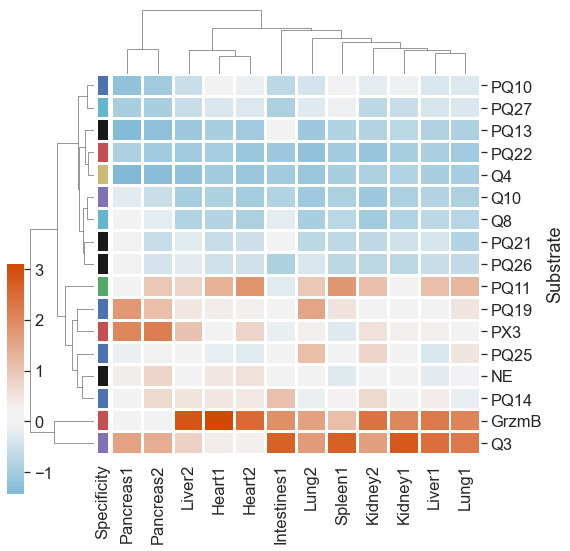

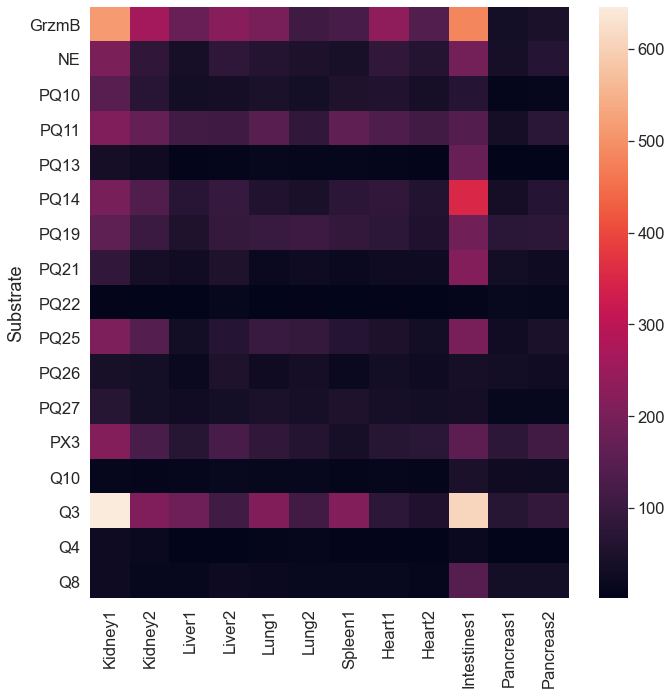

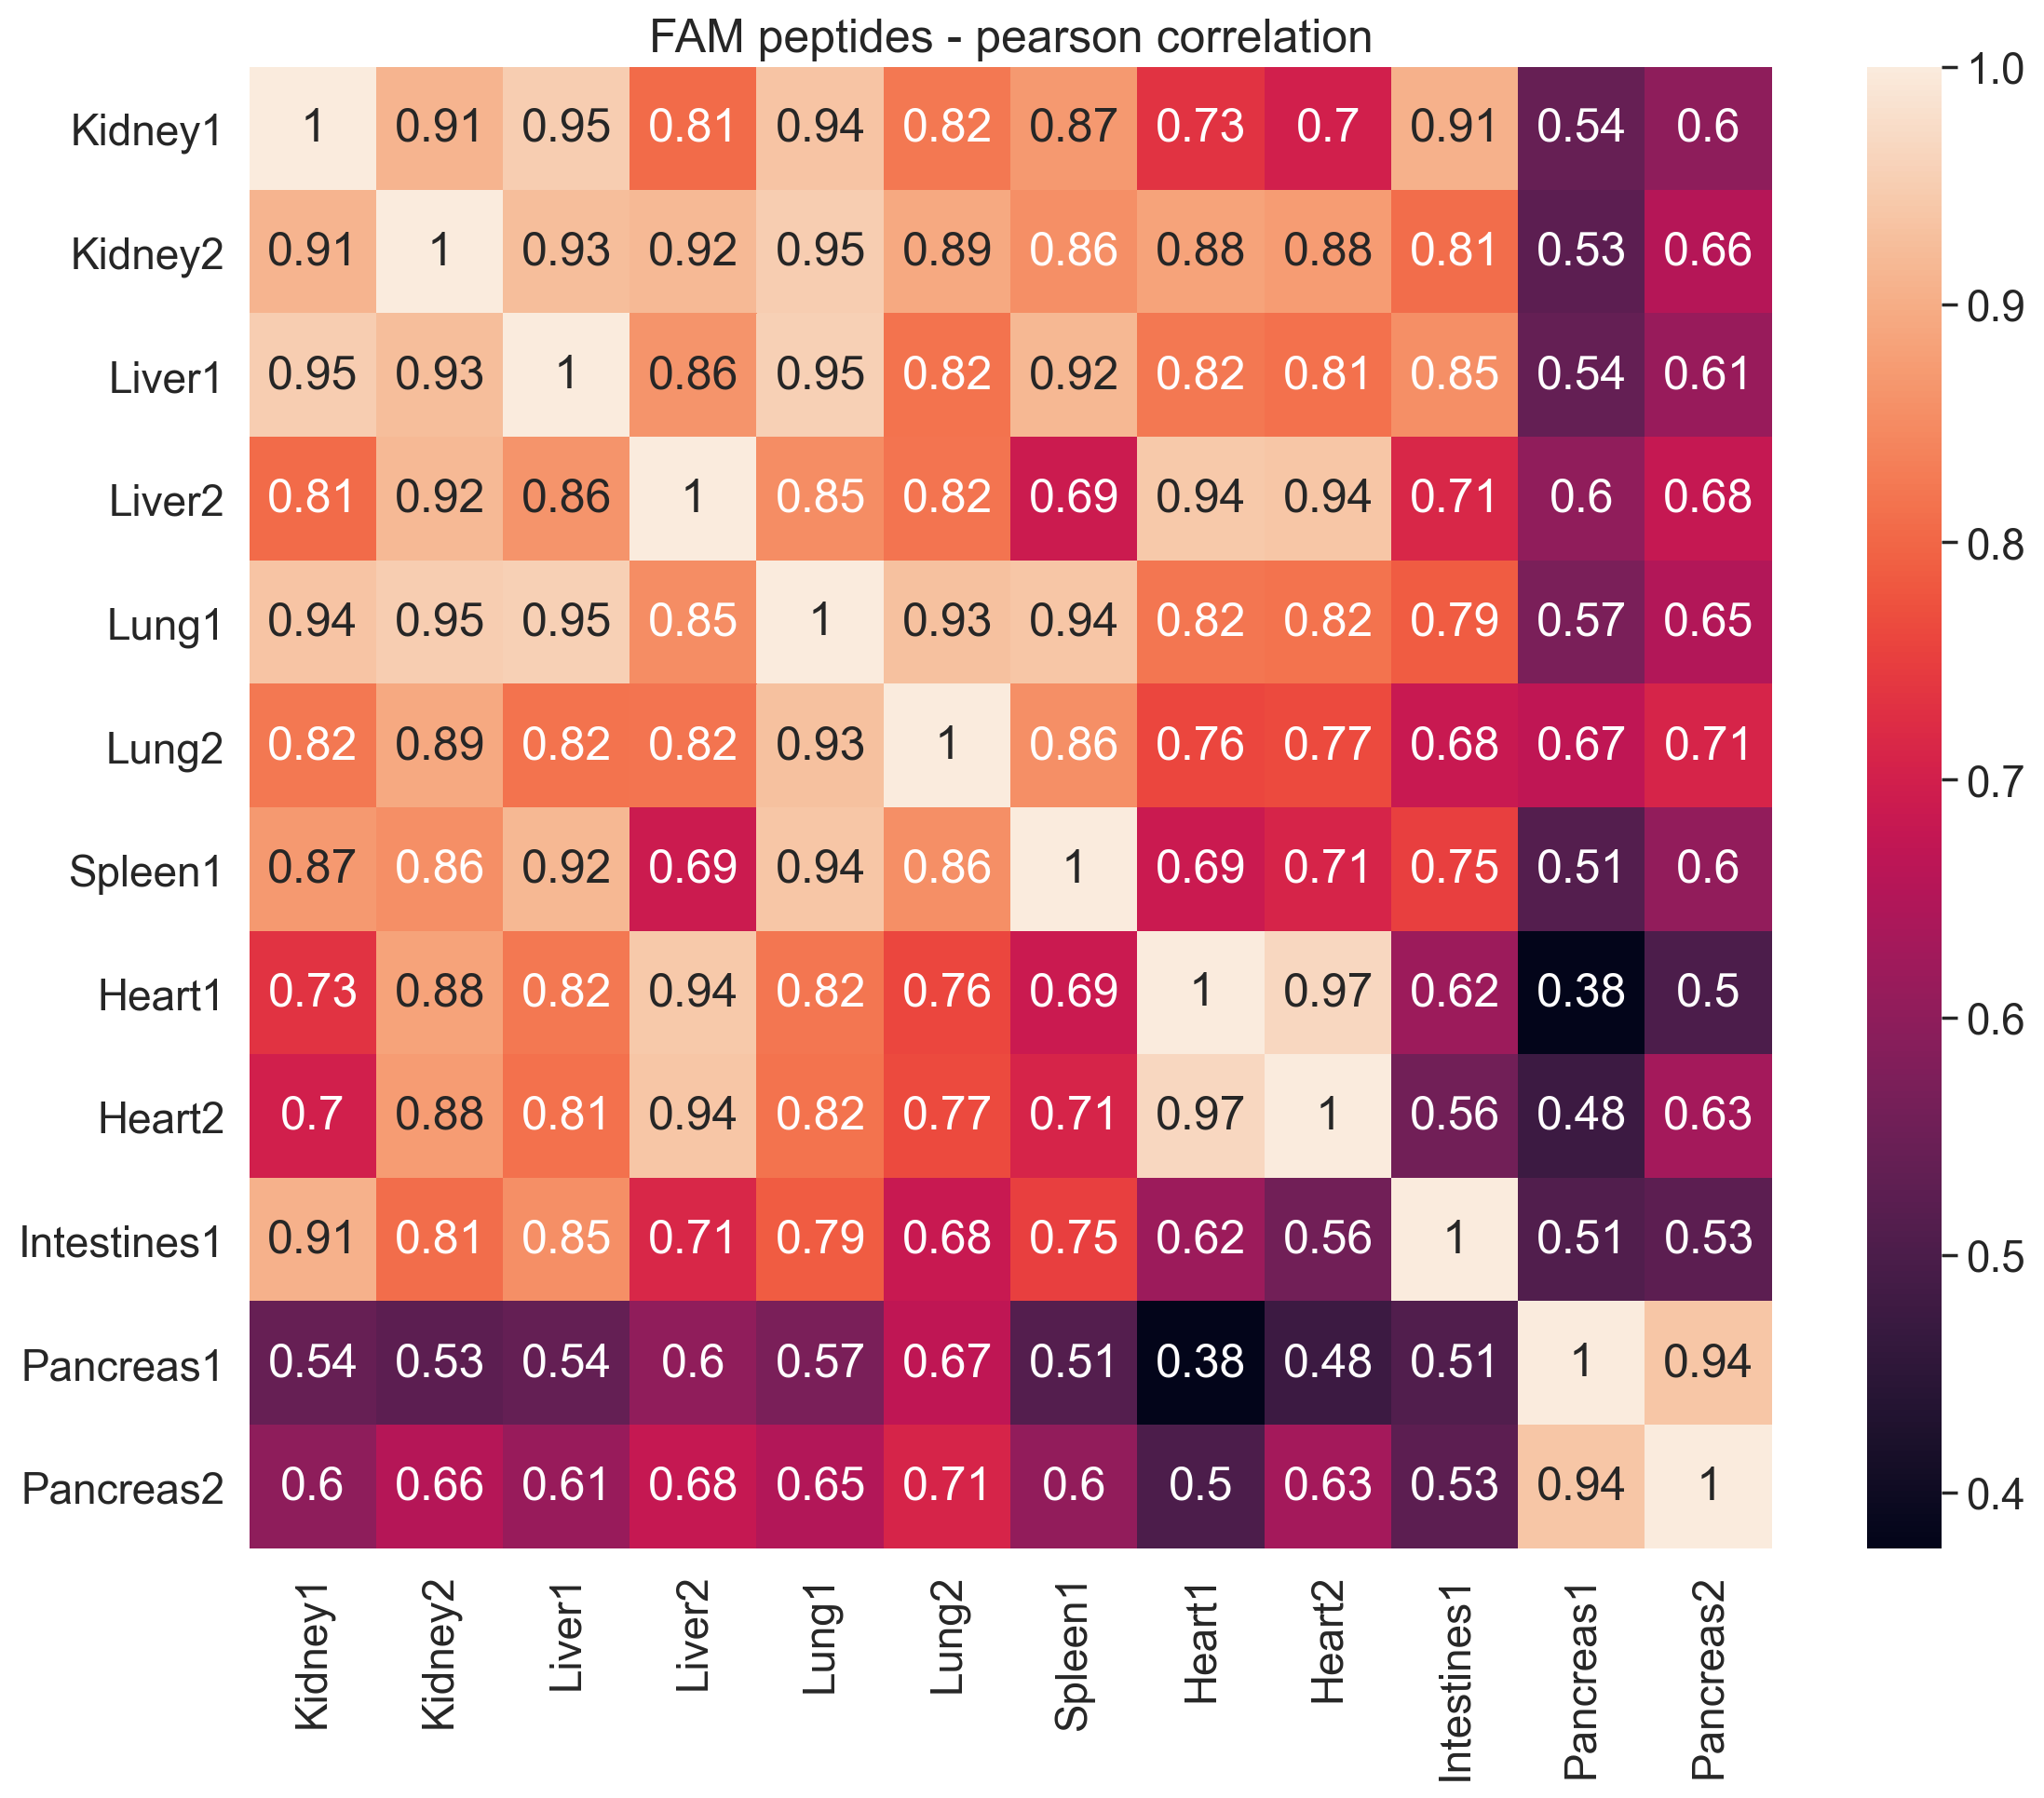

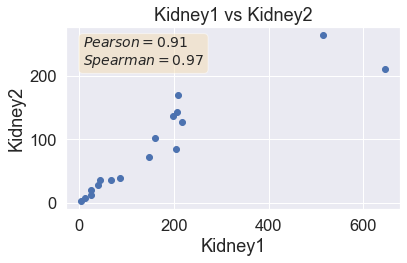

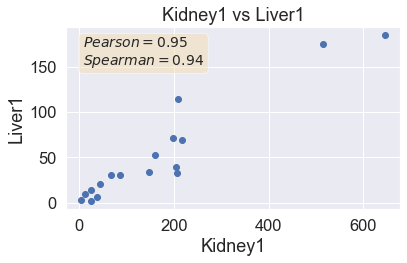

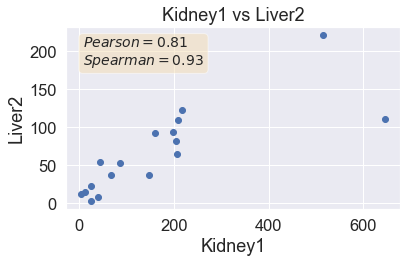

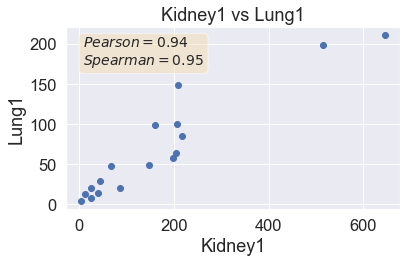

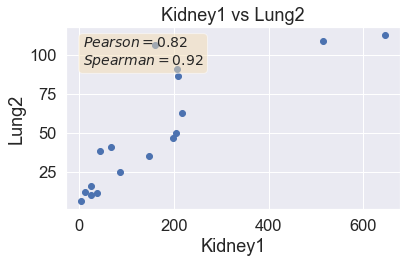

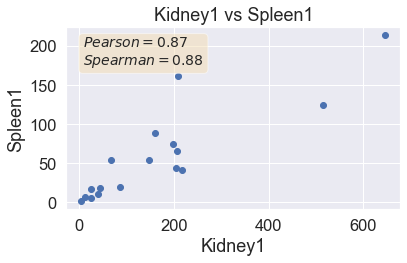

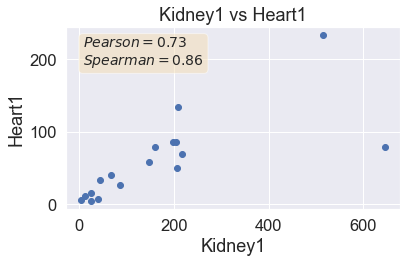

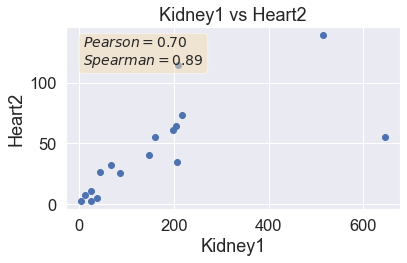

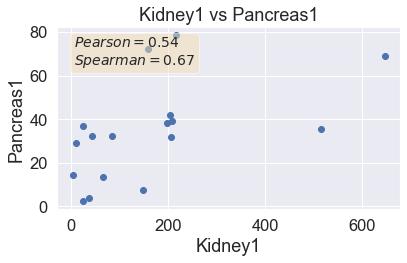

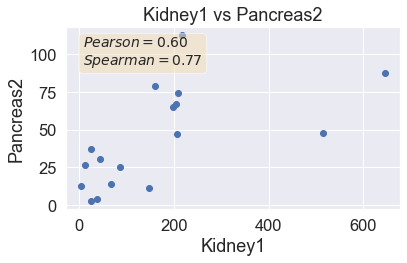

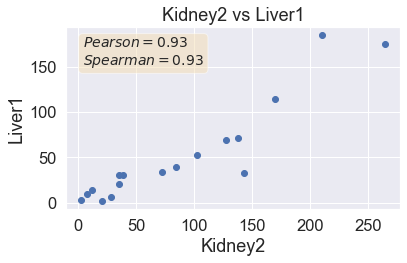

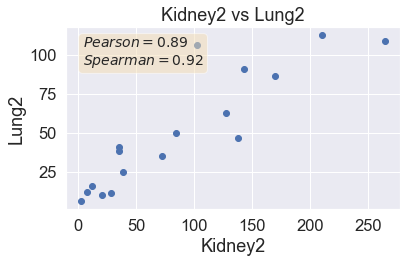

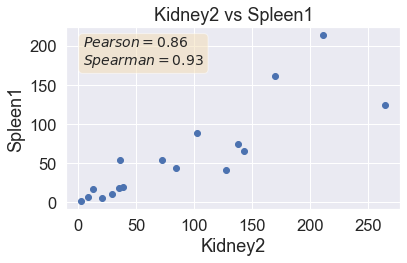

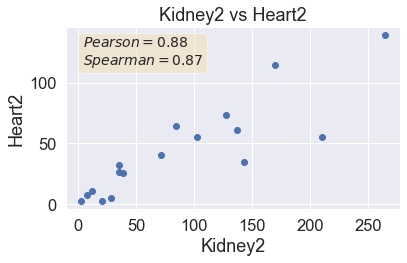

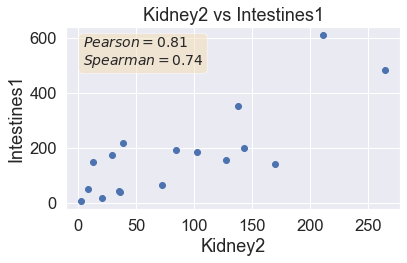

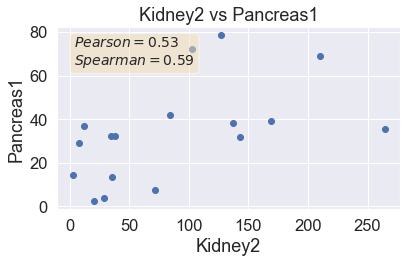

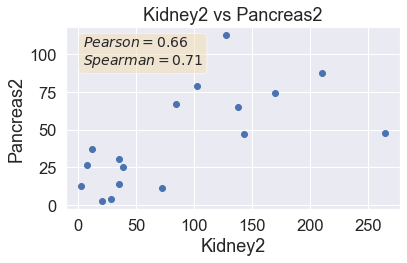

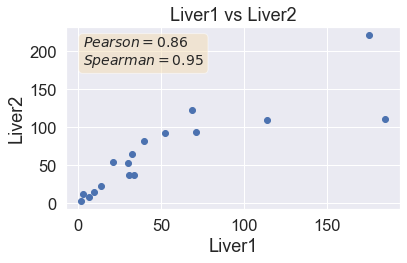

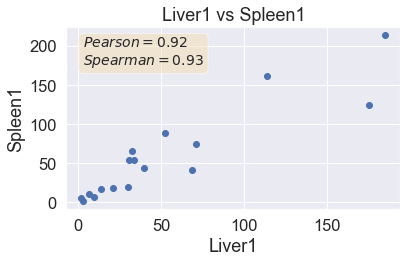

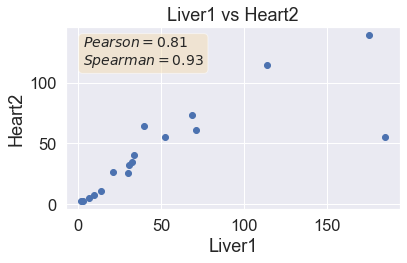

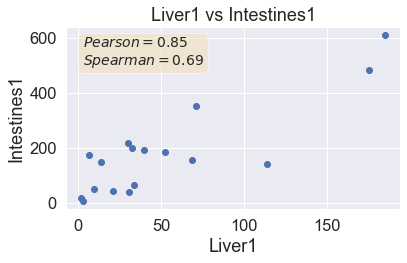

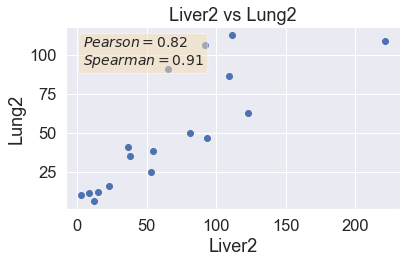

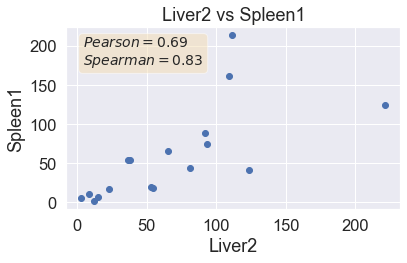

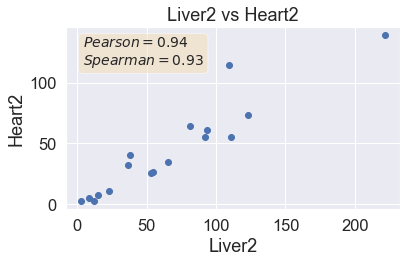

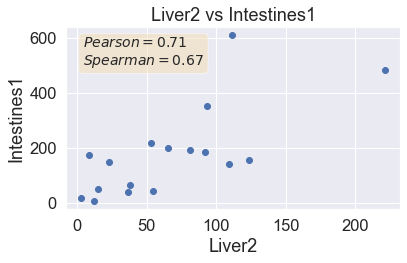

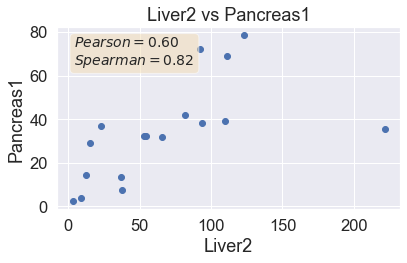

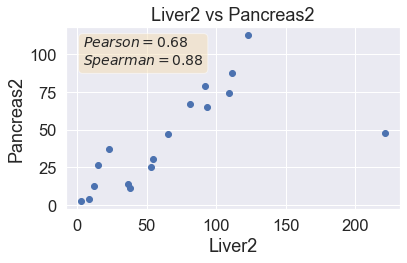

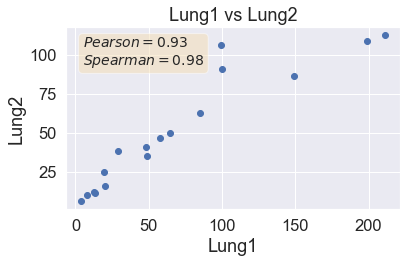

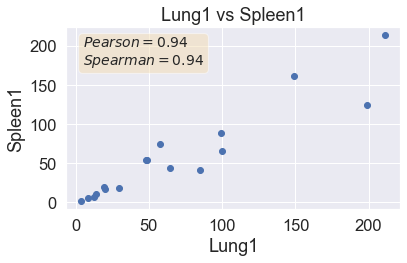

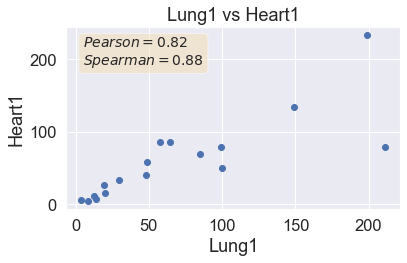

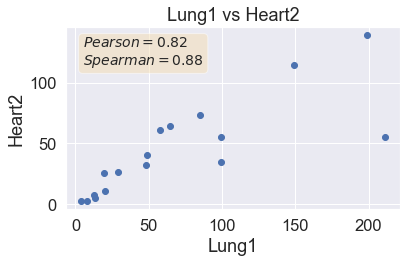

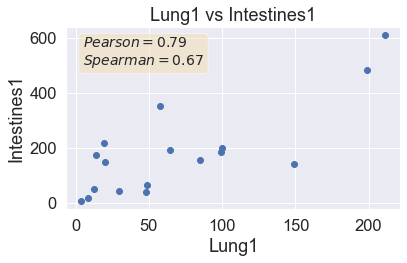

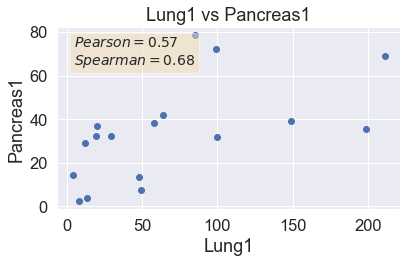

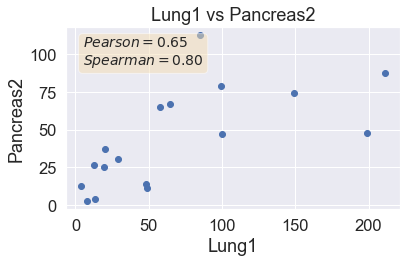

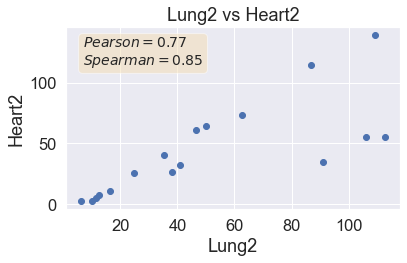

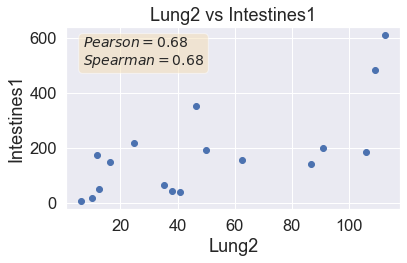

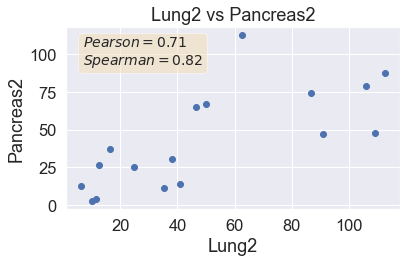

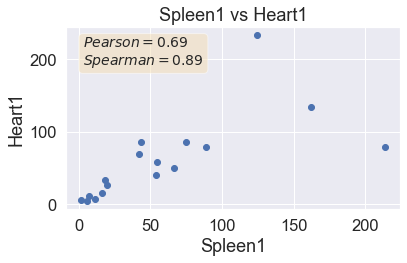

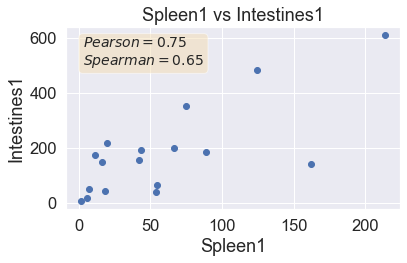

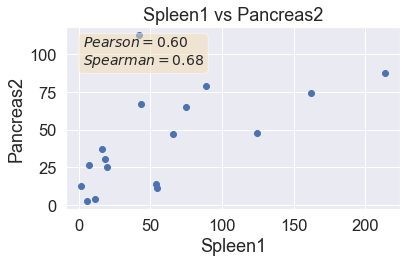

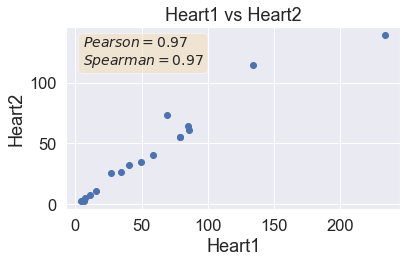

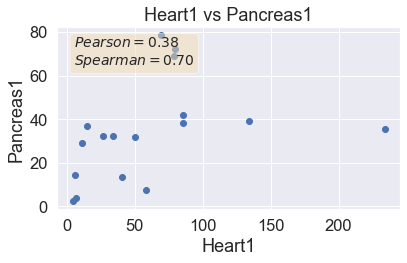

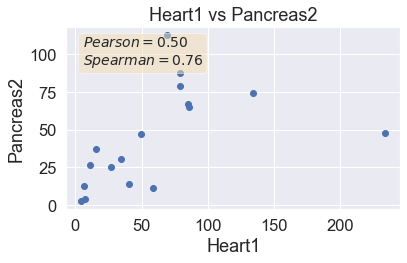

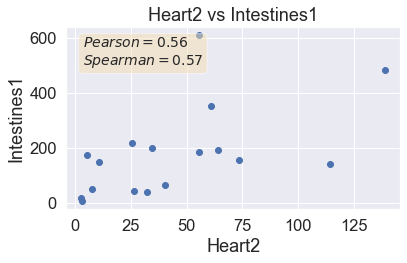

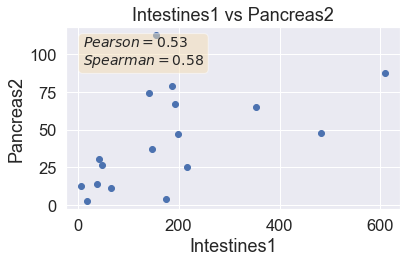

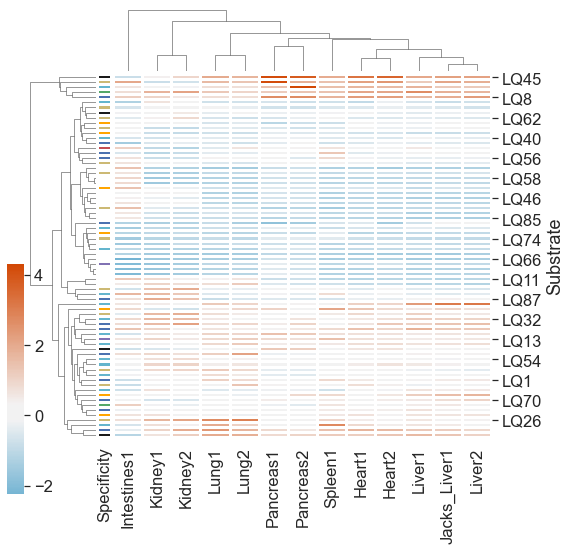

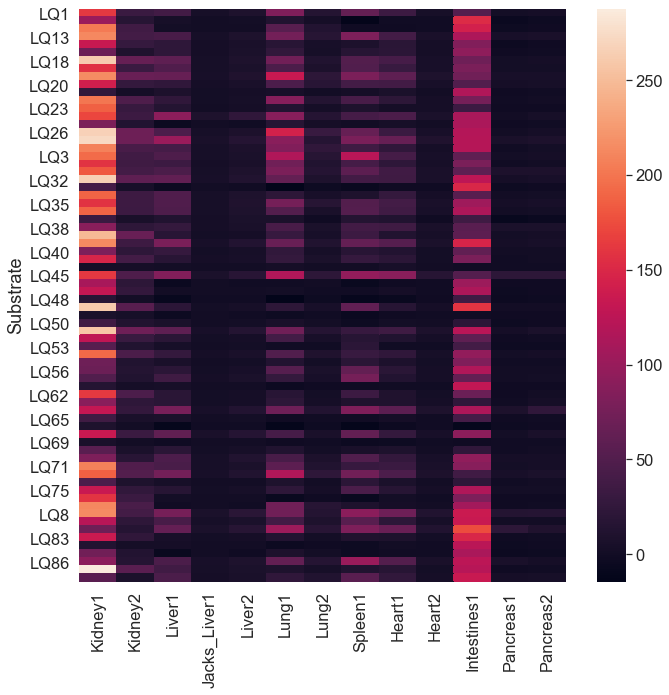

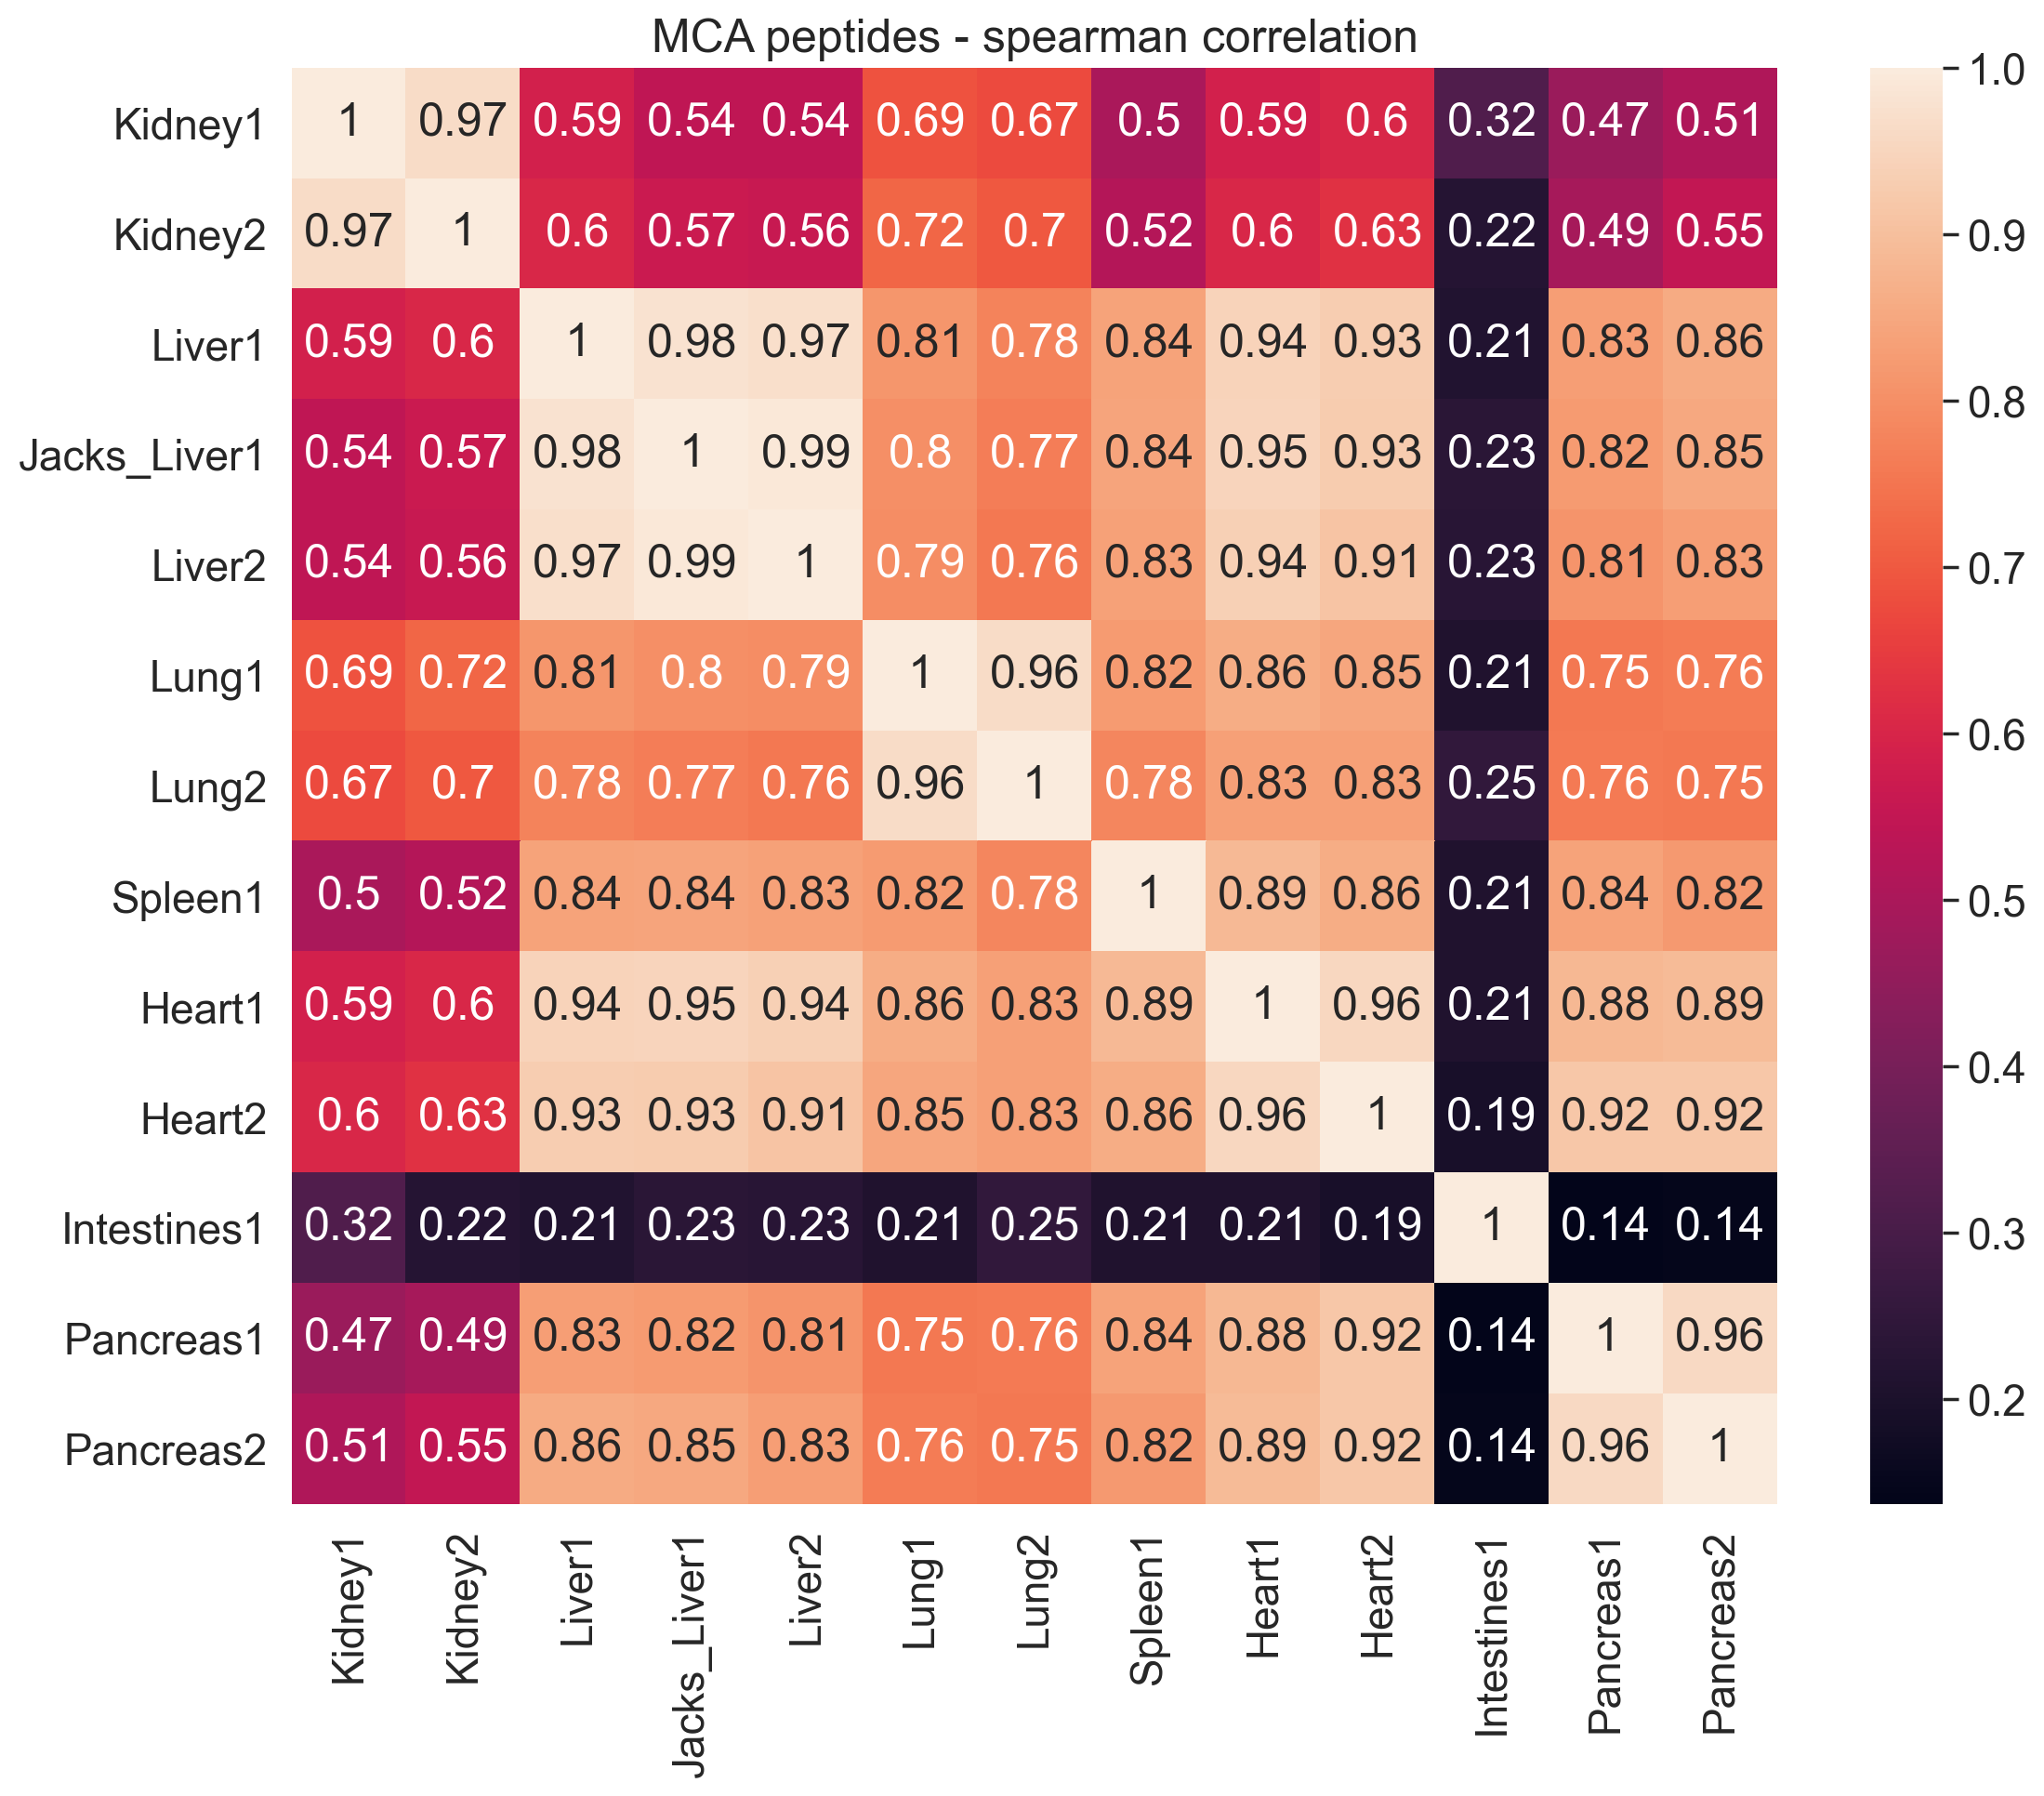

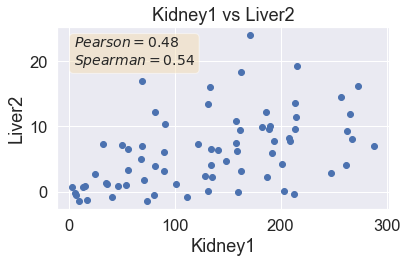

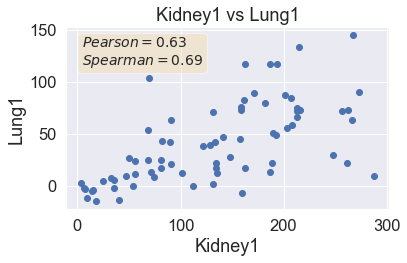

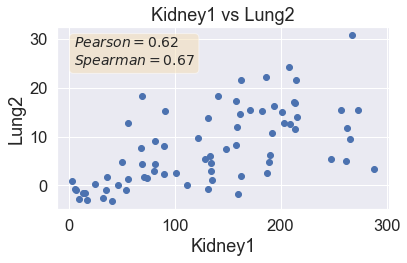

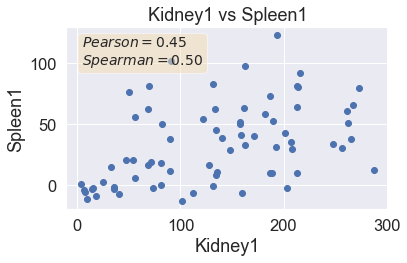

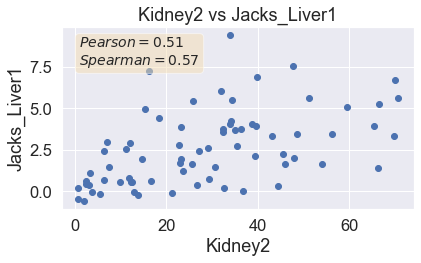

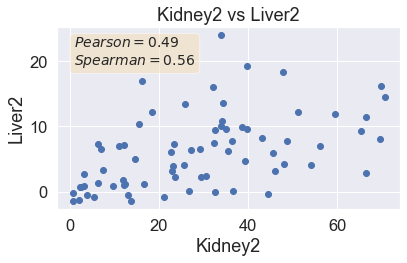

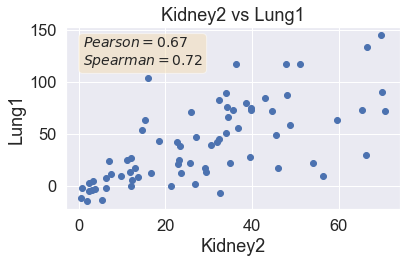

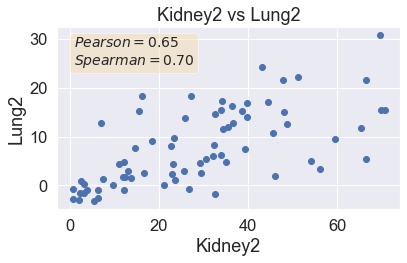

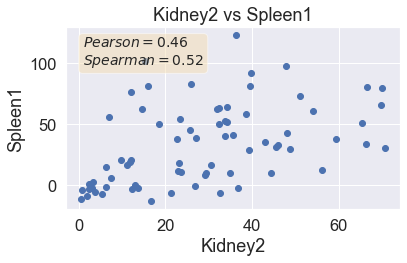

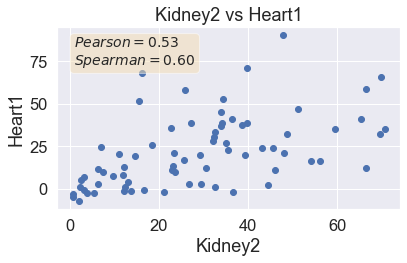

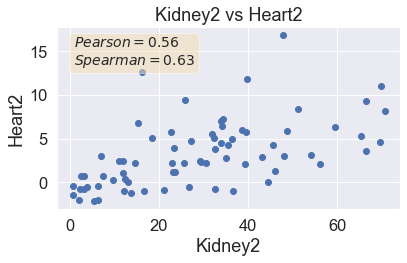

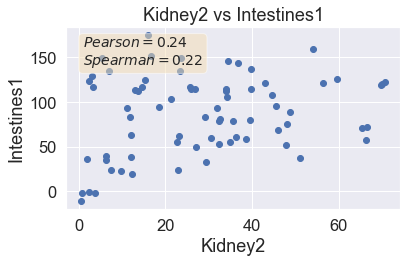

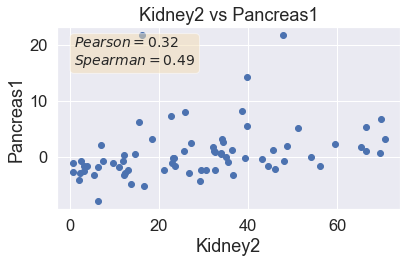

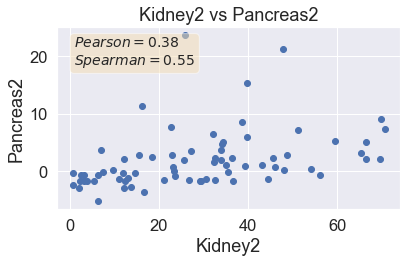

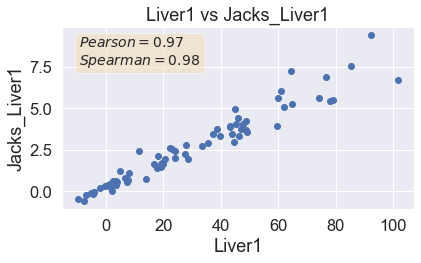

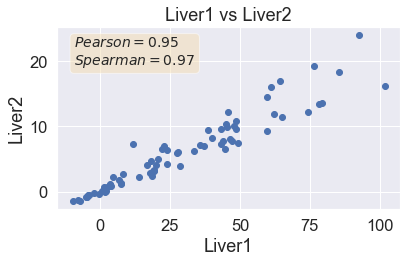

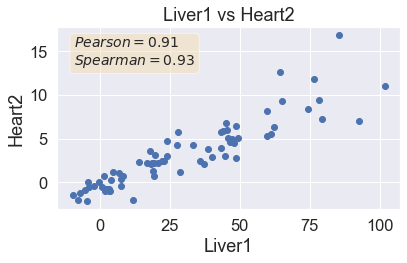

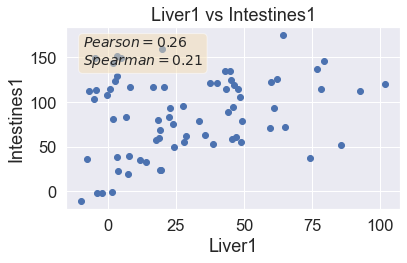

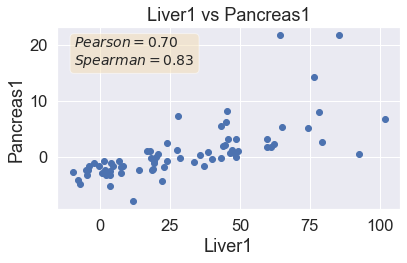

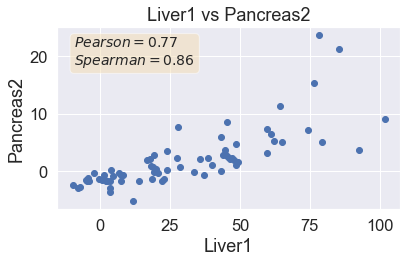

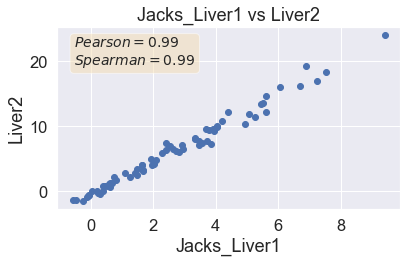

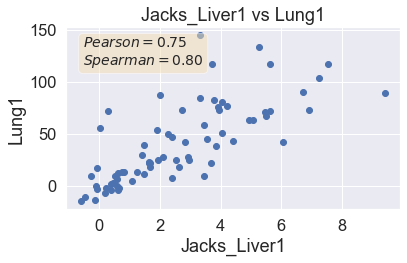

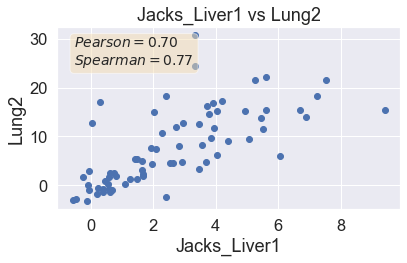

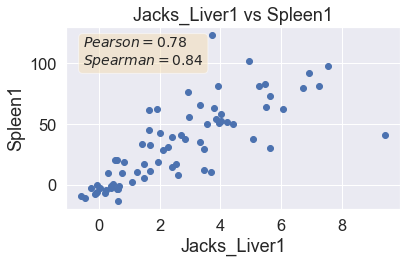

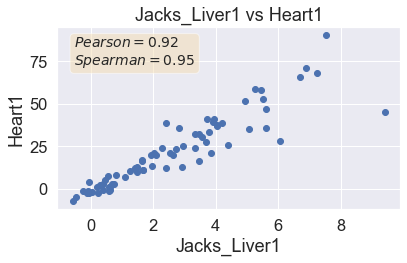

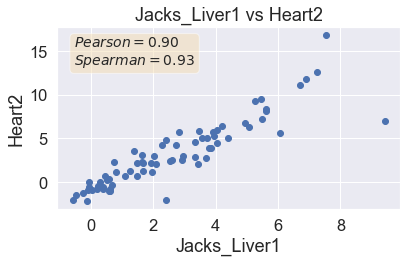

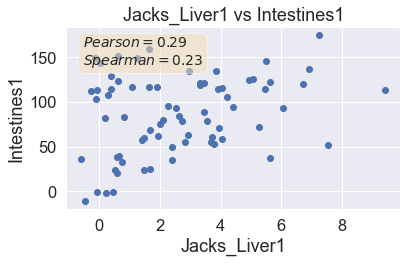

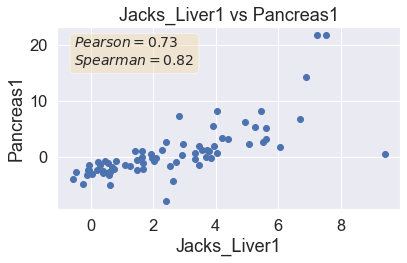

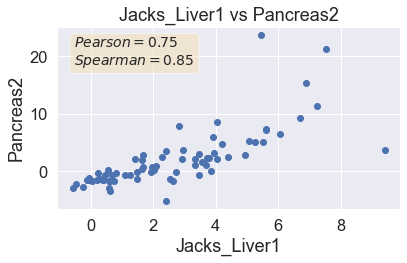

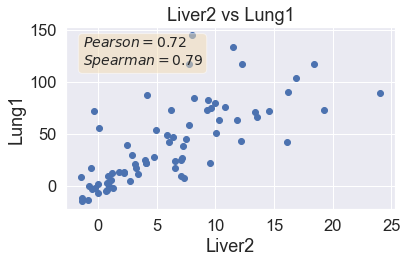

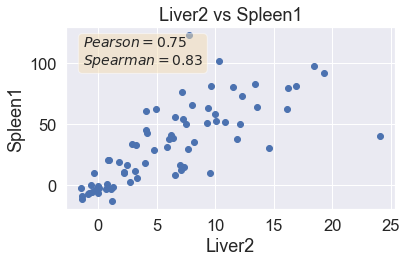

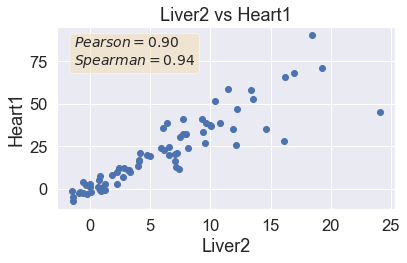

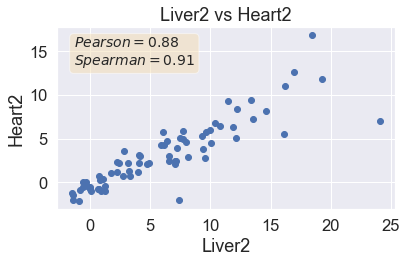

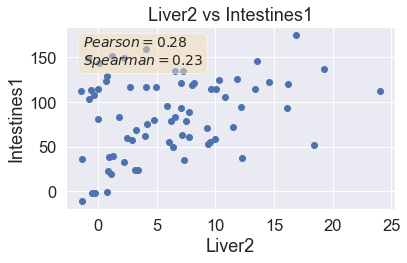

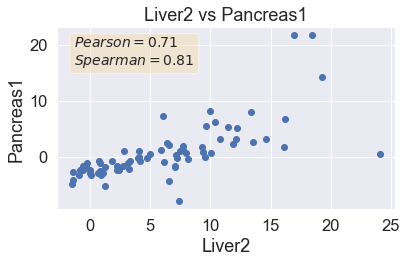

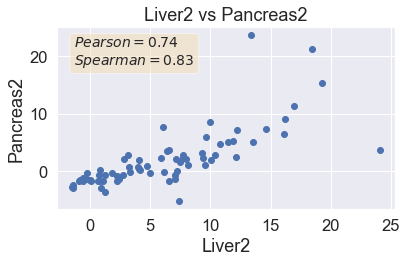

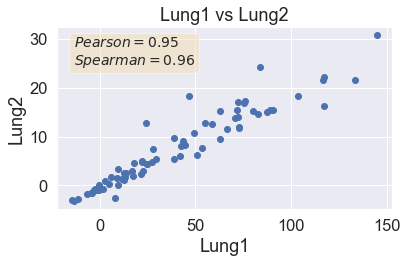

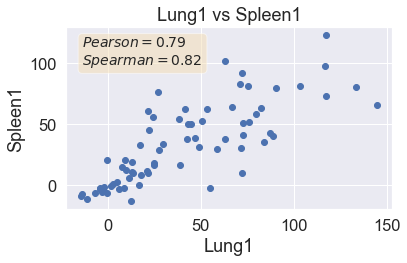

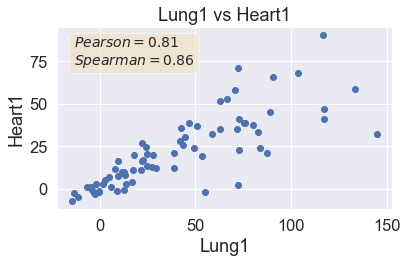

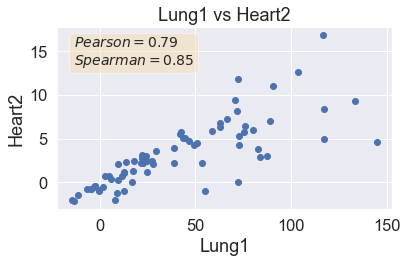

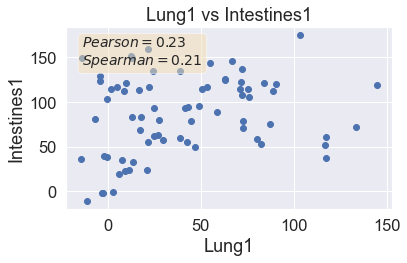

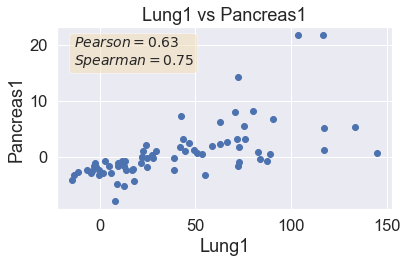

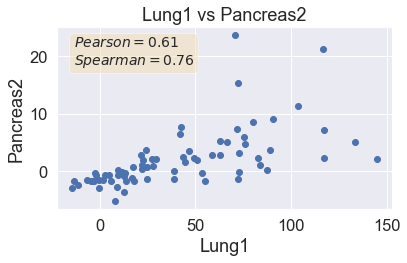

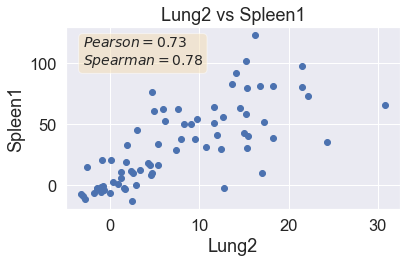

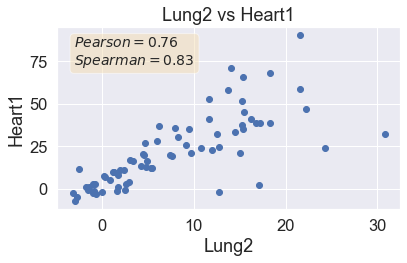

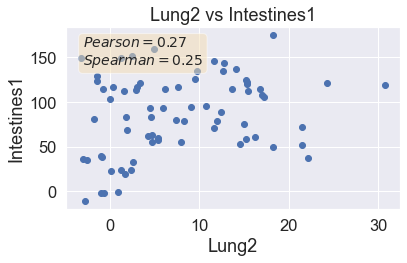

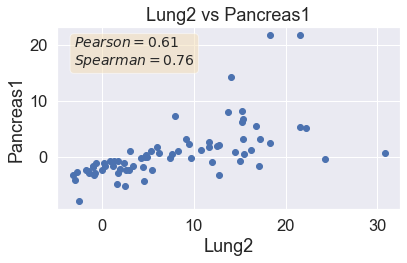

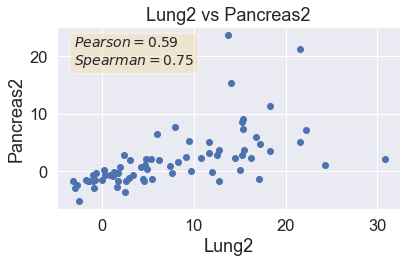

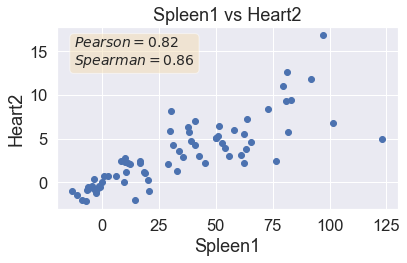

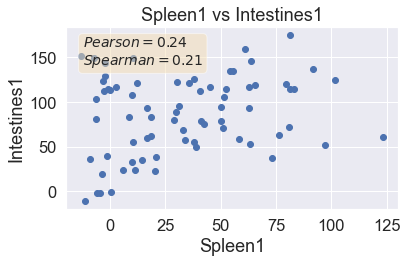

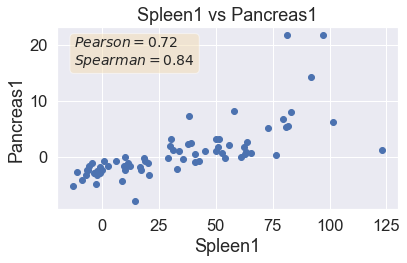

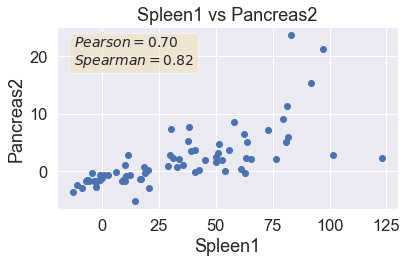

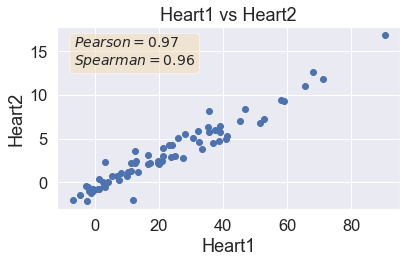

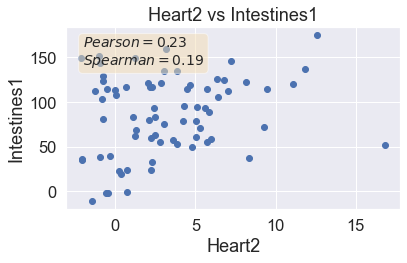

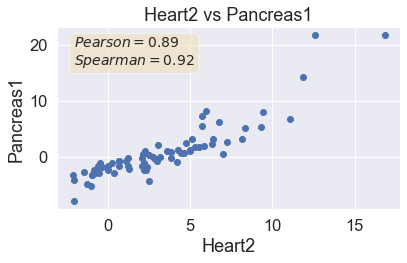

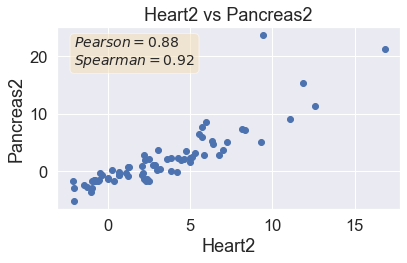

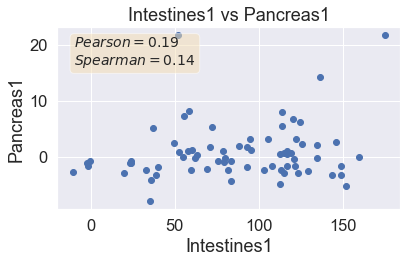

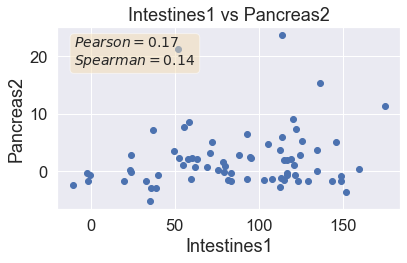

In [14]:
aggregate_data(FAM_df, xd_FAM_df, res_FAM, 'FAM peptides', scale=True, process=True)
aggregate_data(MCA_df, xd_MCA_df, res_MCA, 'MCA peptides', scale=True, process=True)

In [7]:
# mapping between probe name and sequence
f_probes = 'PeptideProbeList.xlsx'
probe_df = pd.read_excel(f_probes)
probe_df

LUAD panel In-house name LCS panel Final Sequence (N- to C-Term) 
0          NaN           NaN       LQ1                      GRQRRVVGG
1          NaN           NaN       LQ2                      GRQARAVGG
2          NaN           NaN       LQ3                      GRRARVVGG
3         PP04            Q6       LQ4                      GPLGLRSWG
4          NaN           NaN       LQ5                    GWEAVRSAMWG
..         ...           ...       ...                            ...
97         NaN           NaN      PQ13                   GSGSKIIGGG-K
98         NaN           NaN      PQ25                      GSYRIFGG-
99         NaN           NaN        Q4                      GGPWGIWGQ
100        NaN           NaN        Q8                   GGf-Pip-RSGG
101        NaN           NaN       Q10                   GGf-Pip-KSGG

[102 rows x 4 columns]

In [8]:
# create dictionary from LCS name and final sequence
seqs = probe_df[probe_df.columns[-1]]
probe_dict = pd.Series(seqs.values, index=probe_df['LCS panel']).to_dict()

In [10]:
# Excel file of cleavage rate values
f_MCA = 'MCA_Correlation_Healthy.xlsx'
MCA_df = pd.read_excel(f_MCA,index_col=0)

f_FAM = 'FAM_Correlation_Healthy.xlsx'
FAM_df = pd.read_excel(f_FAM,index_col=0)

In [11]:
# make dictionary between index number and probe name 
MCA_ind_dict = pd.Series(MCA_df.index, index=range(MCA_df.shape[0])).to_dict()
# MCA_ind_dict

# make dictionary between index number and probe name 
FAM_ind_dict = pd.Series(FAM_df.index, index=range(FAM_df.shape[0])).to_dict()
# FAM_ind_dict

In [12]:
# last couple of columns have non-data values; could manually remove from files before or exclude from dataframe here
MCA_df = MCA_df.iloc[:,:13]
FAM_df = FAM_df.iloc[:,:12]
MCA_df

Kidney1    Kidney2  Liver1  Jacks_Liver1     Liver2   Lung1      Lung2  \
MCA                                                                            
LQ1   161.725  32.500000  38.600      3.783333   9.416667  82.525  14.516667   
LQ10  101.225  16.666667   3.400      0.616667   1.233333  12.650   2.466667   
LQ11  203.100  36.733333   1.975      0.033333   0.100000  55.150  12.766667   
LQ13  213.225  39.666667  43.375      3.916667   9.650000  75.200  16.800000   
LQ16  134.675  29.166667  22.325      2.616667   6.566667  17.675   4.600000   
...       ...        ...     ...           ...        ...     ...        ...   
LQ84   13.875   2.333333   2.475      0.616667   0.700000  -4.400  -1.466667   
LQ85   73.800  13.766667  -7.050     -0.250000  -1.450000   8.925   1.600000   
LQ86   90.725  15.433333  45.050      4.950000  10.350000  62.950  15.250000   
LQ87  287.625  56.266667  37.325      3.450000   7.066667   9.675   3.366667   
LQ9    56.150   6.933333  44.725      2.950000   6.533333  24.375  12.700000   

      Spleen1     Heart1    Heart2  Intestines1  Pancreas1  Pancreas2  
MCA                                                                    
LQ1    63.200  33.300000  3.866667    52.700000      0.925      2.225  
LQ10  -13.075  -0.716667 -1.000000   151.950000     -5.175     -3.525  
LQ11   -2.500  -1.983333 -0.933333   143.416667     -3.175     -1.750  
LQ13   81.525  39.016667  5.733333   114.200000      5.475      5.900  
LQ16    8.475  19.766667  2.500000    83.750000     -4.375     -1.725  
...       ...        ...       ...          ...        ...        ...  
LQ84   -3.375   0.900000 -0.733333   123.666667     -2.850     -1.675  
LQ85   -2.725  -1.216667 -1.250000   112.783333     -4.850     -2.725  
LQ86  101.700  51.633333  6.766667   124.833333      6.175      2.750  
LQ87   12.325  16.383333  2.066667   121.666667     -1.575     -0.625  
LQ9    55.625  24.900000  3.050000   134.516667      2.175      3.725  

[72 rows x 13 columns]

In [11]:
# # drop negative cleavage rates; you can skip this cell if not consistent with previous data analysis
# dropping = process_data(MCA_df)
# MCA_df = MCA_df.drop(index=dropping)

# dropping = process_data(FAM_df)
# FAM_df = FAM_df.drop(index=dropping)

In [13]:
# get z-scores for each sample across tissue type (column), note: population std used by default
z_MCA_df = scale_data(MCA_df)
z_FAM_df = scale_data(FAM_df)

In [14]:
# top n probes 
def top_n(n, df, ind_dict):

    top_df = pd.DataFrame()
    
    for c in df.columns:
        sorted_args = [i[0] for i in sorted(enumerate(df[c]), key=lambda x:x[1], reverse=True)]
        
        # take first n indices
        top_df[c] = sorted_args[:n]
        
        # convert to probe substrate name
        top_probe_df = top_df.replace(ind_dict)

    return top_probe_df

In [15]:
top_MCA_df = top_n(10, z_MCA_df, MCA_ind_dict)
top_FAM_df = top_n(10, z_FAM_df, FAM_ind_dict)

In [15]:
top_MCA_df

Kidney1 Kidney2 Liver1 Jacks_Liver1 Liver2 Lung1 Lung2 Spleen1 Heart1  \
0    LQ87    LQ51   LQ28         LQ24   LQ24  LQ26  LQ26     LQ3   LQ45   
1    LQ28    LQ28   LQ24         LQ45    LQ8   LQ2  LQ29    LQ86    LQ8   
2    LQ26    LQ26   LQ45         LQ82   LQ45  LQ72  LQ72    LQ45   LQ82   
3    LQ32     LQ2    LQ4          LQ8   LQ82   LQ3   LQ2     LQ8   LQ28   
4    LQ18    LQ39   LQ64         LQ28   LQ28  LQ45  LQ45    LQ64    LQ2   
5    LQ49    LQ18    LQ8         LQ68   LQ68  LQ82  LQ82    LQ13   LQ64   
6    LQ51    LQ32   LQ72         LQ51   LQ51  LQ28  LQ20    LQ82    LQ4   
7    LQ39    LQ87    LQ2         LQ72    LQ4  LQ24  LQ35     LQ2   LQ86   
8     LQ8    LQ49   LQ82          LQ4   LQ64  LQ22  LQ79    LQ28   LQ72   
9     LQ2    LQ72   LQ32         LQ64   LQ72  LQ29  LQ13    LQ57   LQ24   

  Heart2 Intestines1 Pancreas1 Pancreas2  
0   LQ45        LQ82      LQ45      LQ64  
1   LQ82        LQ49      LQ82      LQ45  
2    LQ8        LQ10       LQ8       LQ8  
3   LQ28        LQ33      LQ31      LQ82  
4   LQ64        LQ83      LQ64      LQ28  
5    LQ2         LQ4      LQ38      LQ31  
6   LQ72        LQ11      LQ28      LQ38  
7   LQ51         LQ8      LQ86      LQ51  
8    LQ4        LQ81      LQ13      LQ72  
9   LQ24         LQ9       LQ2      LQ68

In [16]:
top_FAM_df

Kidney1 Kidney2 Liver1 Liver2  Lung1  Lung2 Spleen1 Heart1 Heart2  \
0      Q3   GrzmB     Q3  GrzmB     Q3     Q3      Q3  GrzmB  GrzmB   
1   GrzmB      Q3  GrzmB    PX3  GrzmB  GrzmB    PQ11   PQ11   PQ11   
2     PX3    PQ11   PQ11     Q3   PQ11   PQ19   GrzmB   PQ14    PX3   
3    PQ11    PQ25   PQ14   PQ11   PQ25   PQ25    PQ19     NE     NE   
4    PQ25    PQ14    PX3   PQ14   PQ19   PQ11    PQ14   PQ19   PQ14   
5      NE     PX3   PQ19   PQ19    PX3    PX3    PQ25     Q3   PQ19   
6    PQ14    PQ19     NE     NE     NE     NE    PQ10    PX3     Q3   
7    PQ19      NE   PQ10   PQ25   PQ14   PQ14    PQ27   PQ10   PQ10   
8    PQ10    PQ10   PQ25   PQ26   PQ10   PQ27      NE   PQ25   PQ25   
9    PQ21    PQ21   PQ27   PQ21   PQ27   PQ26     PX3   PQ27   PQ27   

  Intestines1 Pancreas1 Pancreas2  
0          Q3       PX3       PX3  
1       GrzmB      PQ19        Q3  
2        PQ14        Q3      PQ19  
3        PQ21        NE      PQ11  
4        PQ25      PQ11        NE  
5          NE      PQ14      PQ14  
6        PQ19        Q8     GrzmB  
7        PQ13     GrzmB      PQ25  
8         PX3      PQ26        Q8  
9          Q8      PQ21      PQ26

In [75]:
# convert probe names to amino acid sequences
top_MCA_seq_df = top_MCA_df.replace(probe_dict)
top_FAM_seq_df = top_FAM_df.replace(probe_dict)
# top_MCA_seq_df
# top_FAM_seq_df

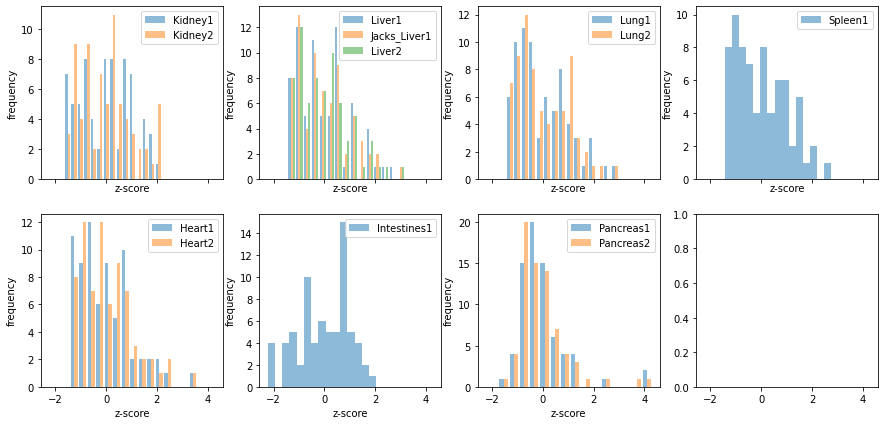

In [14]:
# plot histogram distribution of z-scores for MCA peptides
b=15
a=0.5

fig, ax = plt.subplots(2,4, sharex='all', figsize=(15,7))
   
ax[0,0].hist(z_MCA_df[z_MCA_df.columns[0:2]], bins=b, alpha=a, histtype='bar');
ax[0,0].legend(list(z_MCA_df.columns[0:2]));
ax[0,0].set_xlabel('z-score');
ax[0,0].set_ylabel('frequency');
ax[0,1].hist(z_MCA_df[z_MCA_df.columns[2:5]], bins=b, alpha=a, histtype='bar');
ax[0,1].legend(list(z_MCA_df.columns[2:5]));
ax[0,1].set_xlabel('z-score');
ax[0,1].set_ylabel('frequency');
ax[0,2].hist(z_MCA_df[z_MCA_df.columns[5:7]], bins=b, alpha=a, histtype='bar');
ax[0,2].legend(list(z_MCA_df.columns[5:7]));
ax[0,2].set_xlabel('z-score');
ax[0,2].set_ylabel('frequency');
ax[0,3].hist(z_MCA_df[z_MCA_df.columns[7:8]], bins=b, alpha=a, histtype='bar');
ax[0,3].legend(list(z_MCA_df.columns[7:8]));
ax[0,3].set_xlabel('z-score');
ax[0,3].set_ylabel('frequency');
ax[1,0].hist(z_MCA_df[z_MCA_df.columns[8:10]], bins=b, alpha=a, histtype='bar');
ax[1,0].legend(list(z_MCA_df.columns[8:10]));
ax[1,0].set_xlabel('z-score');
ax[1,0].set_ylabel('frequency');
ax[1,1].hist(z_MCA_df[z_MCA_df.columns[10:11]], bins=b, alpha=a, histtype='bar');
ax[1,1].legend(list(z_MCA_df.columns[10:11]));
ax[1,1].set_xlabel('z-score');
ax[1,1].set_ylabel('frequency');
ax[1,2].hist(z_MCA_df[z_MCA_df.columns[11:13]], bins=b, alpha=a, histtype='bar');
ax[1,2].legend(list(z_MCA_df.columns[11:13]));
ax[1,2].set_xlabel('z-score');
ax[1,2].set_ylabel('frequency');

In [15]:
# plot histogram distribution of z-scores for MCA peptides

b=10
a=0.5

fig, ax = plt.subplots(2,4, sharex='all', figsize=(15,7))
   
ax[0,0].hist(z_FAM_df[z_FAM_df.columns[0:2]], bins=b, alpha=a, histtype='bar');
ax[0,0].legend(list(z_FAM_df.columns[0:2]));
ax[0,0].set_xlabel('z-score');
ax[0,0].set_ylabel('frequency');
ax[0,1].hist(z_FAM_df[z_FAM_df.columns[2:4]], bins=b, alpha=a, histtype='bar');
ax[0,1].legend(list(z_FAM_df.columns[2:4]));
ax[0,1].set_xlabel('z-score');
ax[0,1].set_ylabel('frequency');
ax[0,2].hist(z_FAM_df[z_FAM_df.columns[4:6]], bins=b, alpha=a, histtype='bar');
ax[0,2].legend(list(z_FAM_df.columns[4:6]));
ax[0,2].set_xlabel('z-score');
ax[0,2].set_ylabel('frequency');
ax[0,3].hist(z_FAM_df[z_FAM_df.columns[6:7]], bins=b, alpha=a, histtype='bar');
ax[0,3].legend(list(z_FAM_df.columns[6:7]));
ax[0,3].set_xlabel('z-score');
ax[0,3].set_ylabel('frequency');
ax[1,0].hist(z_FAM_df[z_FAM_df.columns[7:9]], bins=b, alpha=a, histtype='bar');
ax[1,0].legend(list(z_FAM_df.columns[7:9]));
ax[1,0].set_xlabel('z-score');
ax[1,0].set_ylabel('frequency');
ax[1,1].hist(z_FAM_df[z_FAM_df.columns[9:10]], bins=b, alpha=a, histtype='bar');
ax[1,1].legend(list(z_FAM_df.columns[9:10]));
ax[1,1].set_xlabel('z-score');
ax[1,1].set_ylabel('frequency');
ax[1,2].hist(z_FAM_df[z_FAM_df.columns[10:12]], bins=b, alpha=a, histtype='bar');
ax[1,2].legend(list(z_FAM_df.columns[10:12]));
ax[1,2].set_xlabel('z-score');
ax[1,2].set_ylabel('frequency');

In [70]:
# ranked list all peptides above threshold  
def threshold_probes(th, df, ind_dict):

    thresh_df = pd.DataFrame()
    
    for c in df.columns:
        
        # find indices where values greater than threshold
        thr_ind = np.argwhere(np.array(df[c]) > th)
        thr_ind = thr_ind.flatten()
        # list values using indices
        zvals = df.iloc[list(thr_ind)][c]
        # sort indices from greatest to least
        sorted_zvals = np.argsort(-zvals)
        # find substrate names from ordered indices 
        sorted_labels = sorted_zvals.index[sorted_zvals]
        thr_ind_df = pd.DataFrame(sorted_labels)
        # account for different number of substrates greater than threshold in different tissues by concatenating
        thresh_df = pd.concat([thresh_df, thr_ind_df], axis=1)

    thresh_df.columns = df.columns
    return thresh_df

thresh_MCA_df = threshold_probes(1, z_MCA_df, MCA_ind_dict)
thresh_FAM_df = threshold_probes(1, z_FAM_df, FAM_ind_dict)

In [71]:
thresh_MCA_df

Kidney1 Kidney2 Liver1 Jacks_Liver1 Liver2 Lung1 Lung2 Spleen1 Heart1  \
0     LQ87    LQ51   LQ28         LQ24   LQ24  LQ26  LQ26     LQ3   LQ45   
1     LQ28    LQ28   LQ24         LQ45    LQ8   LQ2  LQ29    LQ86    LQ8   
2     LQ26    LQ26   LQ45         LQ82   LQ45  LQ72  LQ72    LQ45   LQ82   
3     LQ32     LQ2    LQ4          LQ8   LQ82   LQ3   LQ2     LQ8   LQ28   
4     LQ18    LQ39   LQ64         LQ28   LQ28  LQ45  LQ45    LQ64    LQ2   
5     LQ49    LQ18    LQ8         LQ68   LQ68  LQ82  LQ82    LQ13   LQ64   
6     LQ51    LQ32   LQ72         LQ51   LQ51  LQ28  LQ20    LQ82    LQ4   
7     LQ39    LQ87    LQ2         LQ72    LQ4  LQ24  LQ35     LQ2   LQ86   
8      LQ8    LQ49   LQ82          LQ4   LQ64  LQ22  LQ79    LQ28   LQ72   
9      LQ2    LQ72   LQ32         LQ64   LQ72  LQ29  LQ13    LQ57   LQ24   
10     LQ4    LQ71   LQ68          LQ2   LQ70   LQ1   LQ3    LQ72    NaN   
11    LQ13     NaN   LQ51         LQ32   LQ32  LQ31   NaN     NaN    NaN   
12    LQ79     NaN   LQ18         LQ86    NaN   NaN   NaN     NaN    NaN   

   Heart2 Intestines1 Pancreas1 Pancreas2  
0    LQ45        LQ82      LQ45      LQ64  
1    LQ82        LQ49      LQ82      LQ45  
2     LQ8        LQ10       LQ8       LQ8  
3    LQ28        LQ33      LQ31      LQ82  
4    LQ64        LQ83      LQ64      LQ28  
5     LQ2         LQ4      LQ38      LQ31  
6    LQ72        LQ11      LQ28      LQ38  
7    LQ51         LQ8      LQ86      LQ51  
8     LQ4        LQ81       NaN      LQ72  
9    LQ24         LQ9       NaN       NaN  
10    NaN         NaN       NaN       NaN  
11    NaN         NaN       NaN       NaN  
12    NaN         NaN       NaN       NaN

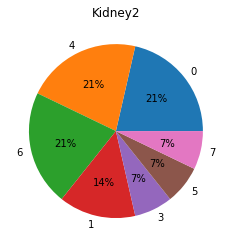

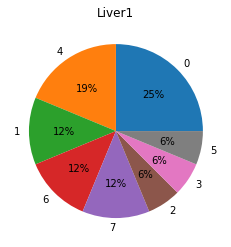

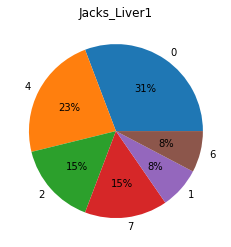

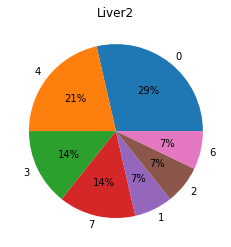

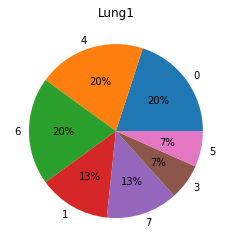

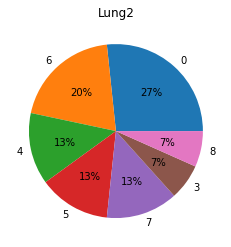

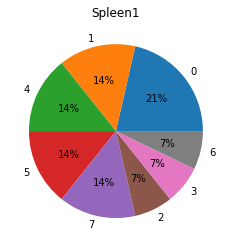

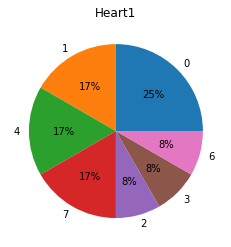

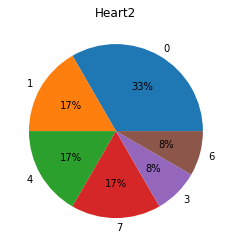

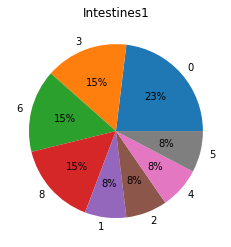

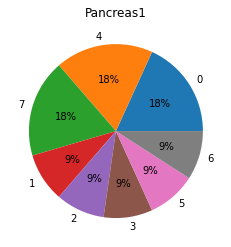

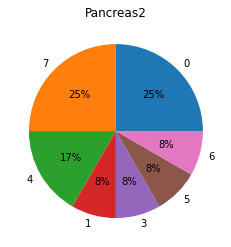

In [127]:
# thr_df: probe list dataframe (use thresholded probes dataframe)
# dict_df: use xd dataframe (from earlier) as dictionary to convert probe name to inhibitor label

def probe_class_proportion(thr_df, dict_df):
        
    # convert substrate name to dictionary classification
    class_dict = dict_df.to_dict()
    c_dict = class_dict['Specificity']
    converted_df = thr_df.replace(c_dict)
    
    for c in converted_df.columns:
        # pull out given column 
        one_column = converted_df[c]
        # drop any NaN values
        one_column_noNaN = one_column.dropna()
        # make all classifications consistently int values
        one_column_int = one_column_noNaN.astype(int)
        # count frequency of each classification
        counts = one_column_int.value_counts()
        # plot
        plt.figure();
        plt.pie(counts,labels=counts.index, autopct='%1.f%%');
        plt.title(c)
        
# combine MCA and FAM dataframes
combined_thr_df = pd.concat([thresh_MCA_df, thresh_FAM_df], ignore_index=True)
# combine MCA and FAM dictionaries
combined_dict = pd.concat([xd_MCA_df, xd_FAM_df])

probe_class_proportion(combined_thr_df, combined_dict)

In [ ]:
# for a given tissue sample (Melodi's plot)
# data: dataframe of tissue sample across columns and substrate across rows (MCA_df, FAM_df in this case above)
# threshold: z-scores above this threshold will be labeled on plot 
def specificity_analysis(data, out_path, threshold=1):

    # remove negative cleavage rates
    dropping = process_data(data)
    data = data.drop(index=dropping)
    
    # z-score by column (tissue sample/condition, cleavage efficency)
    cl_z = scale_data(data)
    
    # z-score by row (probe, substrate specificity)
    dataT = data.transpose()
    dataT = scale_data(dataT)
    sp_z = dataT.transpose()
        
    # number of samples
    n = data.shape[1]
    
    # plot for each sample
    for i in range(n):
        x = cl_z.iloc[:,i]
        y = sp_z.iloc[:,i]

        plt.figure()
        plt.scatter(x,y, s=30)
        plt.xlabel('Cleavage efficiency')
        plt.ylabel('Specificity')
        plt.title(data.columns[i])
        plt.tight_layout()

        labels = data.index
        for j, txt in enumerate(labels):
            # could change threshold to be different between x and y
            if x[j] > threshold or y[j] > threshold:
                plt.annotate(txt, (x[j], y[j]), fontsize=12)
#             if x[j] > 1 and y[j] > 1:
#                 print(txt)
                
        plt.savefig(os.path.join(out_path, 'specificity_analysis for ' + str(data.columns[i]) + '.png'))

In [ ]:
specificity_analysis(MCA_df, res_MCA)